## Geostatistical Modeling


### By:  Moses Adekoje - 404125

## Part 1: Creating sample points from choice image

### 1.1 Loading image into Python as Grayscale

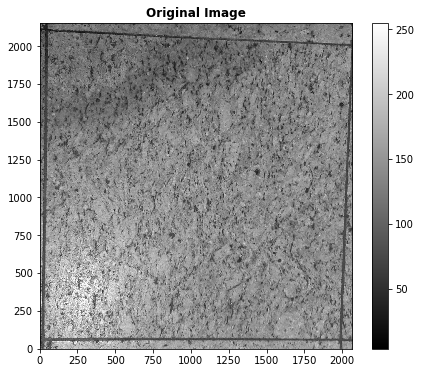

In [1]:
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
im = plt.imread('Image_404125.jpg')
grayscale_im = color.rgb2gray(im) * 255
plt.figure(figsize=(7,6))
plt.imshow(grayscale_im, cmap='gray', origin='lower left')
plt.title('Original Image', weight='bold')
plt.colorbar();

This image is the flooring of the Köln Hauptbahnhof. I chose it because it showed very interesting spatial characteristics; this turned out to be true from the analyses.


### 1.2 Creating a sample set randomly from the original image

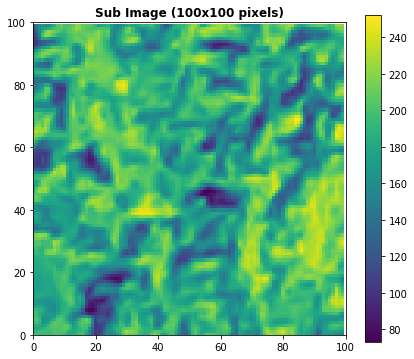

In [2]:
n_random_points = 100
np.random.seed(123456)
im_sub = grayscale_im[100:200, 100:200] #new 100x100 pixels sub-image used for analysis
x_max, y_max = im_sub.shape
x_random = np.random.uniform(0,x_max,n_random_points)
y_random = np.random.uniform(0,y_max,n_random_points)
training_vals = im_sub[x_random.astype('int'),y_random.astype('int')]

plt.figure(figsize=(7,6))
plt.imshow(im_sub)
plt.xlim(0,x_max)
plt.ylim(0,x_max)
plt.title('Sub Image (100x100 pixels)', weight='bold')
plt.colorbar();

## Part 2: Performing standard statistical analyses of the sampled points

First we check if the spatial characteristics or variability of the data can be reproduced using basic statistical parameters like mean and standard deviation. This result is best in images which have a normal distibution. Hence, we check for this first by using a **Gaussian distribution function** and secondly by using a **QQ Plot**.

### 2.1 Creating histogram and checking for normal distribution

#### 2.1.1 Using a Gaussian distribution

In [3]:
mean, std_dev = np.mean(training_vals), np.std(training_vals)
print('The mean of the training values is: %.2f' %mean)
print('The Standard deviation of the training values is: %.2f' %std_dev)

The mean of the training values is: 181.31
The Standard deviation of the training values is: 27.27


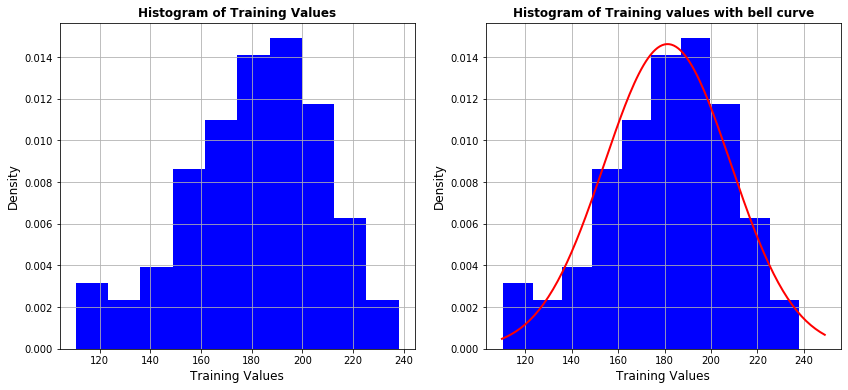

In [4]:
def gaussian(x, mu, sigma):
    """To describe a normal distibution
    
    **Arguments**:
        x: array of positions for the normal distribution
        mu: mean values of the data
        sigma: standard deviation of the data
     """
    a = 1/(sigma*np.sqrt(2*np.pi))
    b = 2.718281**(-0.5*((((x-mu)/sigma))**2))
    function_x = a * b
    return function_x

fig, axes = plt.subplots(1,2, figsize=(14,6))
axes[0].hist(training_vals, color='blue', bins=10, density=True, rwidth=2)
axes[0].set_xlabel('Training Values', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Histogram of Training Values', weight='bold')
axes[0].grid();


axes[1].hist(training_vals,color='blue', bins=10, density=True, rwidth=2)
axes[1].set_xlabel('Training Values', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
x = np.arange(110,250)
axes[1].plot(x, gaussian(x, mean, std_dev), 'r',linewidth=2)
axes[1].set_title('Histogram of Training values with bell curve', weight='bold')
axes[1].grid();

#### 2.1.2 Secondly, using a Q-Q Plot

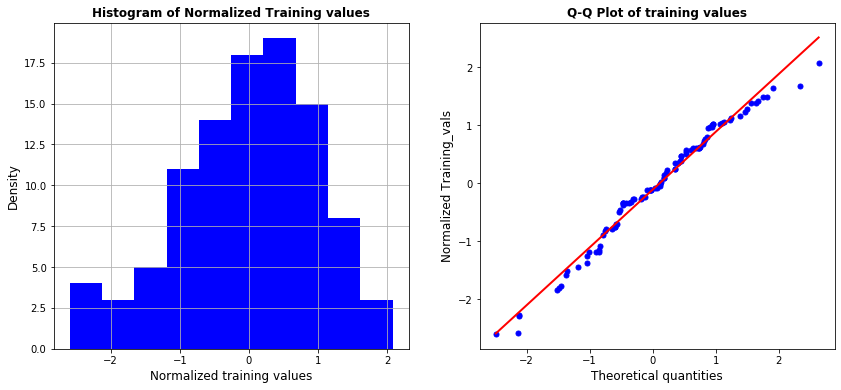

In [5]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
norm_training_vals = np.array((training_vals - mean)/std_dev)
axs[0].hist(norm_training_vals, color = 'blue', rwidth=2)
axs[0].set_xlabel('Normalized training values', fontsize=12)
axs[0].set_ylabel('Density', fontsize=12)
axs[0].set_title('Histogram of Normalized Training values', weight='bold')
axs[0].grid()


sorted_training_vals = np.sort(norm_training_vals)
np.random.seed(6)
random_dist = np.random.normal(0, 1, size=(len(sorted_training_vals)))
sorted_random_dist = np.sort(random_dist)
slope, intercept = np.polyfit(sorted_random_dist, sorted_training_vals, 1)
lin_reg_func = intercept + slope*sorted_random_dist
axs[1].plot(sorted_random_dist, sorted_training_vals, 'bo', markersize=5)
axs[1].plot(sorted_random_dist, lin_reg_func, 'r-', linewidth=2)
axs[1].set_xlabel('Theoretical quantities', fontsize=12)
axs[1].set_ylabel('Normalized Training_vals', fontsize=12)
axs[1].set_title('Q-Q Plot of training values', weight='bold');

### 2.2 Generating a new random image

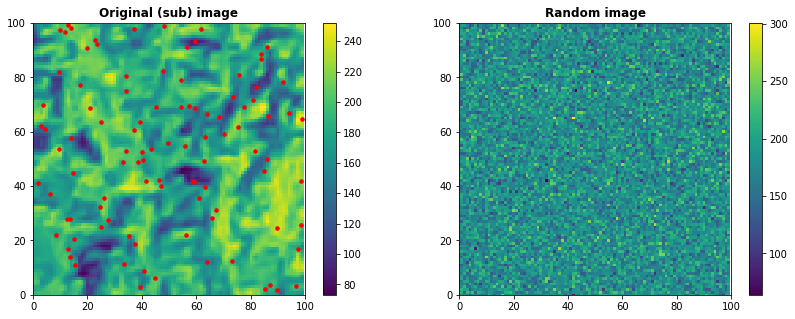

In [6]:
random_samples = np.random.normal(mean, std_dev, size=(im_sub.shape)) #pixel values for random numbers
fig, axs = plt.subplots(1,2, figsize=(14,5))

original_image = axs[0].imshow(im_sub, origin = 'lower left') #subimage
axs[0].plot(x_random, y_random, 'r.', markersize=7) #training values
axs[0].set_title('Original (sub) image', weight='bold')
axs[0].set_xlim(0,x_max)
axs[0].set_ylim(0,x_max)
fig.colorbar(original_image, ax=axs[0])

random_image =axs[1].imshow(random_samples, origin = 'lower left') #randomly generated image
axs[1].set_title('Random image', weight='bold')
axs[1].set_xlim(0,x_max)
axs[1].set_ylim(0,x_max)
fig.colorbar(random_image, ax=axs[1]);

### Summary of Part 2:

The histogram showed a normal distribution, this was also confirmed by the gaussian distribution curve and the QQ plot which both give the all-clear for attempting to reproduce the spatial variation of the original image using it's mean and standard deviation. However, this failed as there is almost no spatial correlation between the random image and the original image. This confirms that the reproduction of the spatial characteristics of the pixels in the original image would definitely require a geostatistical approach.

## Part 3: Determining a variogram model for the data

The aim of this section is to build a model that shows the spatial relationship (covariance) of all the pixel values contained in the image, with the aim of determining a maximum lag distance where variability plateaus (range) and the corresponding variance at this point (sill).

In [7]:
# we need the dist_matrix and semi-variance matrix to plot the experimental variogram
import scipy.spatial.distance as distance
position_array = np.array(list(zip(x_random, y_random))) #position of training values
dist_matrix = distance.squareform(distance.pdist(position_array))

def semivariance(training_vals):
    """Compute semi variance matrix of an array of values
    
    **Arguments**:
        training_vals: 1D array of values 
    """
    n = len(training_vals)
    semi_vmatrix = np.ones((n,n))
    for i in range(n):
        for j in range(n):
            semi_vmatrix[i,j] = 0.5*(training_vals[i]-training_vals[j])**2
    return semi_vmatrix

semi_vmatrix = semivariance(training_vals)

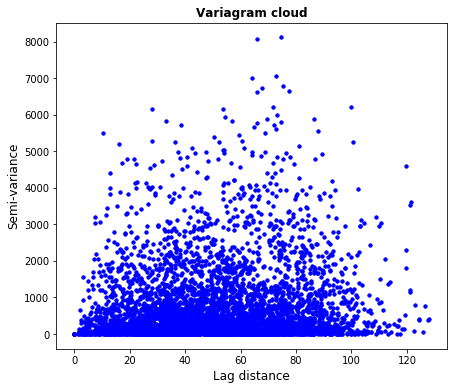

In [8]:
#variogram cloud
plt.figure(figsize=(7,6))
plt.plot(dist_matrix.flatten(), semi_vmatrix.flatten(), 'b.')
plt.xlabel('Lag distance', fontsize=12)
plt.ylabel('Semi-variance',fontsize=12)
plt.title('Variagram cloud', weight='bold');

In [9]:
#masking operation
dist_btw_points = dist_matrix.flatten()
semi_variance = semi_vmatrix.flatten()
mask = np.where(dist_btw_points<=50)
dist_btw_points = dist_btw_points[mask]
semi_variance = semi_variance[mask]

### 3.1 Experimental Variogram

In [10]:
import scipy.stats as stats
statistic, bin_edges, bin_number = stats.binned_statistic(dist_btw_points, semi_variance, statistic='mean', bins=50, range=None)
bin_means = statistic #average semivariance for each bin
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

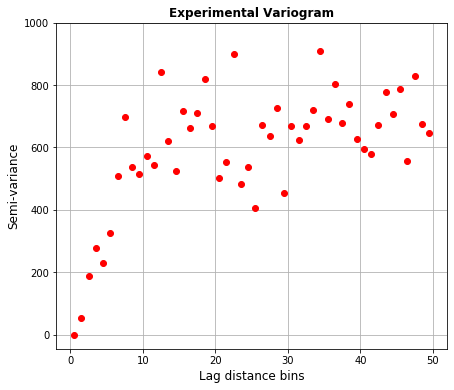

In [11]:
#plotting the experimental variogram
plt.figure(figsize=(7,6))
plt.plot(bin_centers,bin_means, 'ro')
plt.grid()
plt.xlabel('Lag distance bins',fontsize=12)
plt.ylabel('Semi-variance',fontsize=12)
plt.ylim(None, 1000)
plt.title('Experimental Variogram', weight='bold');

### 3.2 Theoretical Variogram

In [12]:
def expo_var(lag, a, b):
    """Exponential variogram function
    
    **Arguments**:
        lag: lag distance range
        a: range value
        b: sill value
    """
    return b * (1 - np.exp((-3 * lag)/a))


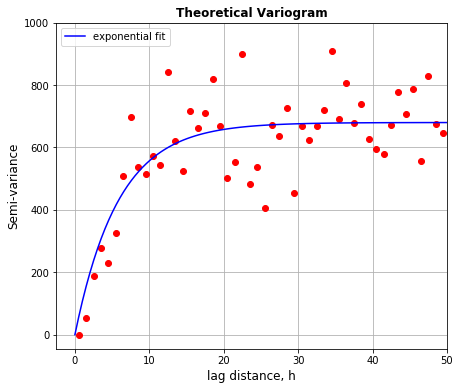

In [13]:
#Automatic curve-fitting method to find an optimal fit:
import scipy.optimize
from scipy.optimize import curve_fit

par_a, par_b = curve_fit(expo_var, bin_centers, bin_means) #range and sill of the variogram

x_min, x_max = 0, 50 
x_fit = np.linspace(x_min, x_max, 100) #to extend the fit to origin (0,0) and x=50
plt.figure(figsize=(7,6))
plt.plot(bin_centers, bin_means, 'ro')
plt.plot(x_fit, expo_var(x_fit, par_a[0], par_a[1]), 'b', label='exponential fit')
plt.xlim(None,50)
plt.ylim(None,1000)
plt.title('Theoretical Variogram', weight='bold')
plt.grid()
plt.xlabel('lag distance, h', fontsize=12)
plt.ylabel('Semi-variance', fontsize=12)
plt.legend(loc='upper left', fontsize=10);

In [14]:
Range = par_a[0] #range
sill = par_a[1] #sill
print('The range of the variogram is = %.2f' %Range)
print('The sill of the variogram is = %.2f' %sill)

The range of the variogram is = 17.54
The sill of the variogram is = 679.89


### Summary of Part 3:

The focus of this part was to visualize the variogram and obtain optimal values for the range and the sill. The experimental variogram was also plotted, however, it won't be used in further analysis steps. The variogram cloud does not tell much story, plotting it was mostly for sighting.

## Part 4 

## Simple kriging on subset of points

### 4.1 Defining the Covariance function

In [15]:
def covariance(lag, a=Range, b=sill):
    """Covariance function
    
    **Arguments**:
        lag: lag distance range
        a: range value
        b: sill value
    """
    return b * (np.exp((-3 * lag)/a))


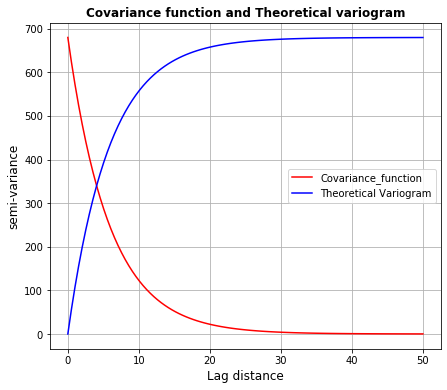

In [16]:
#Relating the covariance function and theoretical variogram
cov_values = np.vectorize(covariance)
variogram_values = np.vectorize(expo_var)
h=np.linspace(0,50,100)
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
plt.plot(h, cov_values(h, Range, sill), 'r-', label = 'Covariance_function')
plt.plot(h, variogram_values(h, Range, sill), 'b-', label = 'Theoretical Variogram')
plt.grid()
plt.xlabel("Lag distance", fontsize=12)
plt.ylabel("semi-variance", fontsize=12) 
plt.title("Covariance function and Theoretical variogram", weight='bold')
plt.legend(loc='best');

When the variation is bounded (that is, a sill value can be defined), then the Covariance function and the theoretical variogram mirror each other as shown above. They are related to each other by the equation;


$$C(h) = C(0) - \gamma(h)$$



### 4.2 Performing Simple Kriging Interpolation

In [17]:
#define an empty grid
empty_grid = np.ones((im_sub.shape))
x_max, y_max = empty_grid.shape
columns = np.arange(0,y_max,1)
rows = np.arange(0,x_max,1)
unknown_position  = np.array([[(i,j) for j in columns] for i in rows])
unknown_position = unknown_position.reshape(10000,2) #position of unknown values

In [18]:
def simple_kriging_func(x_pos, pos, vals, covariance):
    """Performs simple kriging estimation
    
    **Arguments**:
        x_pos: array of known positions
        pos: position of unknown value
        vals: array of training values (according to positions)
        covariance: covariance function
    """
    c = np.ones(len(x_pos))
    for i in range(len(x_pos)):
        c[i] = covariance(distance.euclidean(x_pos[i], pos))
    C = covariance((distance.cdist(x_pos,x_pos)))
    
    w = np.linalg.solve(C,c)
                              
    Z = np.mean(vals) + np.sum(w*(vals-np.mean(vals)))
                               
    return Z
    
    

In [19]:
#to execute the interpolation for multiple positions
kriging_result = []

for i in range(len(unknown_position)):
    kr_result = simple_kriging_func(position_array, unknown_position[i], training_vals, covariance)
    kriging_result.append(kr_result)

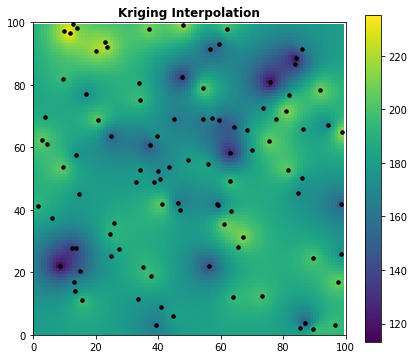

In [20]:
#visualizing the kriging result
interp_values = np.array(kriging_result).reshape(im_sub.shape).T
fig = plt.figure(figsize=(7,6))
plt.xlim(0,x_max)
plt.ylim(0,x_max)
plt.imshow(interp_values, origin = 'lower left')
plt.plot(x_random, y_random, 'k.', markersize=7) #training values
plt.colorbar()
plt.title('Kriging Interpolation', weight='bold');

### 4.3 Estimating the Kriging Variance

In [21]:
def simple_kriging_var(x_pos, pos, vals, covariance):
    """Estimate simple kriging variance
    
    **Arguments**:
        x_pos: array of known positions
        pos: position of unknown value
        vals: array of training values (according to positions)
        covariance: covariance function
    """

    n = len(x_pos)
    c = np.ones(len(x_pos))
    for i in range(len(x_pos)):
        c[i] = covariance(distance.euclidean(x_pos[i], pos))
    C = covariance((distance.cdist(x_pos,x_pos)))
    
    w = np.linalg.solve(C,c)
    
    variance = covariance(0)-np.sum(w*c)
                               
    return variance

In [22]:
#to execute the interpolation variance for multiple positions
result_var = []

for i in range(len(unknown_position)):
    kr_var_result = simple_kriging_var(position_array, unknown_position[i], training_vals, covariance)
    result_var.append(kr_var_result)

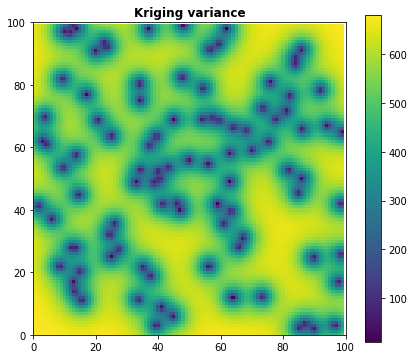

In [23]:
#visualizing the result of the kriging variance
interp_variance = np.array(result_var).reshape(im_sub.shape).T
fig = plt.figure(figsize=(7,6))
plt.xlim(0,x_max)
plt.ylim(0,x_max)
plt.imshow(interp_variance, origin = 'lower left')
plt.colorbar()
plt.title('Kriging variance', weight='bold');

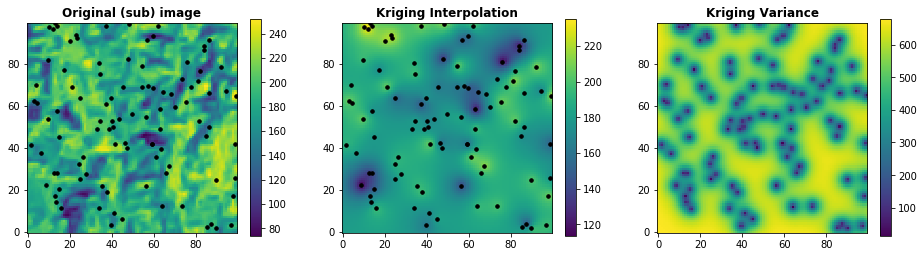

In [24]:
#visualizing all images for comparison
fig, axs = plt.subplots(1,3, figsize=(plt.figaspect(1/4)))
original_image = axs[0].imshow(im_sub, origin = 'lower left') #subimage or real image
axs[0].plot(x_random, y_random, 'k.', markersize=7) #training values
interpolated_values = axs[1].imshow(interp_values,origin = 'lower left') #interpolated values
axs[1].plot(x_random, y_random, 'k.', markersize=7) #training values
kriging_variance = axs[2].imshow(interp_variance, origin = 'lower left') #kriging variance

fig.colorbar(original_image, ax=axs[0])
fig.colorbar(interpolated_values, ax=axs[1])
fig.colorbar(kriging_variance, ax=axs[2])

axs[0].set_title('Original (sub) image', weight='bold')
axs[1].set_title('Kriging Interpolation', weight='bold')
axs[2].set_title('Kriging Variance', weight='bold');

### Summary of Part 4:
Using training values from the original (sub) image, simple kriging was executed with a defined covariance function. Corresponding kriging variance was also estimated for each location; both results are highlighted above.

## Part 5: Performing Sequential Gaussian simulation

Sequential gaussian simulation is introduced to fix the smoothing problem of the simple kriging interpolation as a result of  the missing variance; the aim is to impose the correct global spatial variation into these estimates.

**Simulated value = Krigged estimate + Random residual**

This can be achieved by drawing values from a normal distribution using krigged estimates as the mean, with the variance being their corresponding kriging variance at each step since we are working in a gaussian space.


In [25]:
simulated_values = []
np.random.seed(1234)
for i in range(len(kriging_result)):
    value_random_location = kriging_result[i] #iterating over each kriging estimate
    variance_random_location = result_var[i] #iterating over each corresponding kriging variance

#next step is to draw simulation value from a normal distribution using kriging mean and kriging variance
#Note that the krigged estimate is the mean
    sim_val = np.random.normal(value_random_location, np.sqrt(variance_random_location))
    simulated_values.append(sim_val)

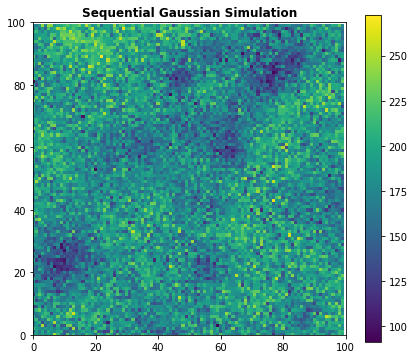

In [26]:
plt.figure(figsize=(7, 6))
plt.imshow(np.array(simulated_values).reshape(100,100).T, origin= 'lower left')
plt.colorbar()
plt.xlim(0,x_max)
plt.ylim(0,x_max)
plt.title('Sequential Gaussian Simulation', weight='bold');

## Part 6: Interpretation of results

A major assumption to note here for this interpolation is stationarity. Even though the scope of this analysis does not require checking for the stationarity of the dataset, it is indeed a general assumption for simple kriging interpolation procedures that stationarity exists locally within the spatial domain. In otherwords, measured (or known) data points exhibit similar differences over the same lag distance at different localities within the spatial domain.

**Variogram**<br>
The experimental variogram allows us to examine the spatial relationship between the measured (known) points with closer points points proving to be more alike, this similarity gradually reduces with increase in distance between the points. The experimental variogram gives a pretty clear idea of this relationship. The lag distance data was masked to limit the highest lag to 50; this value was chosen because above this lag distance, we do not expect any form of spatial relationship between points and it would best to neglect it completely. Also, i chose a bin size of 2 simply because my highest lag distance is now 50 so this affords me room to really hone in on what is left of the data since a lot of irrelevant parts have been chopped off. 

Just by eyeballing the experimental variogram, i would assume a range of 15 and a sill of about 620. Of course, this is totally intuitive and there is still the need to apply a more assertive method of determining that, hence the need to fit a theoretical variogram to it. Range and sill values of 17.68 and 678.96 respectively are obtained and is then used to define the covariance function for the simple kriging interpolation and kriging variance steps. Correlation is zero away from the sill and is equal to the variance of the dataset.

$$\sigma^2_{ } = C(0)$$

#### Kriging Interpolation
Kriging is an estimation approach that relies on linear weights accounting for spatial continuity, data closeness and redundancy and is defined by:
$$ Z^*_{\omega_{SK}}(x_0)= \mu+\sum_{i=1}^{n}\omega_i (Z(x_i) - \mu)$$

Kriging values rely so much on the variogram. The variogram determines how the covariance function is defined and this covariance function is introduced into the kriging interpolation in an attempt to reproduce the spatial relationship of the pixel values from the original image. However, away from the range of the data, the simple kriging variance is equal to the variance of the dataset meaning there is maximum uncertainty and complete smoothing at these data locations. The simple kriging approach focuses more on local accuracy, sacrificing global accuracy in the process and as a result misrepresents the spatial continuity from the original image. For this reason, kriging is not used directly for mapping spatial distribution of an attribute, except when only interpolation is needed. It is used, however, for building conditional distributions for stochastic simulations. Albeit so, kriging provides the best local estimate at each unknown location.

The kriging variance at each location is defined by:
$$\sigma^2_{SK} = C(0) - \sum_{i=1}^{n} \omega^{SK}_i C(x_i-x_0)$$
    
#### Sequential Gaussian Simulation
The goal of the sequential gaussian simulation is to add the missing variance in the krigged estimates. Away from the range of the data, the variance is zero and this lack of variability produces a complete smoothing effect during the kriging interpolation. The SGS step is introduced to try and add the missing variability in an attempt to show a better spatial heterogeneity of the krigged estimates. This also means that the we do not have the correct covariance between the unknown locations from the krigging step; which makes sense because the values were estimated independent of one another and as such their spatial correlation with one another is inaccurate. In an attempt to fix this problem, we need to define the following:

$$\sigma^2_{ } = C(0)$$
                                        
We assume that this variance is staionary and should be constant everywhere within the grid.

Also, the covariance between the krigged estimates and the data is correct, however, the variance is too small:

$$ Var_{kriggedestimates} = \sigma^2_{ } - \sigma^2_{SK}$$
                                        
Hence, the missing variance is the Simple kriging variance $\sigma^2_{SK}$. The SGS step is for adding this missing variance using the previoulsy krigged values as data so that we may reproduce the covariance from the original image in the simulated values.

The resulting image from the SGS step shows a better heterogeneity which makes assessment of global uncertainty possible. Also, multiple realizations is possible by changing the random number seed. Contrary to the kriging result, the SGS calculates a reasonable estimate at each location and focuses on global accuracy, sacrificing local accuracy in the process.